In [37]:
!rm -rf Qtok
!git clone https://github.com/nup-csai/Qtok.git

Cloning into 'Qtok'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 575 (delta 112), reused 152 (delta 57), pack-reused 347 (from 1)
Receiving objects: 100% (575/575), 322.78 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (213/213), done.
Updating files: 100% (377/377), done.


In [38]:
!pip install -U tokenizers
!pip install adjustText
!pip install squarify


In [39]:
import json, os
from tokenizers import Tokenizer

In [40]:
# Generate a byte to character mapping
def generate_bytes_char_mapping():
    """
    Generates byte-to-character and character-to-byte mappings consistent with the Rust encoder.

    Returns:
        byte_to_char (dict): Maps each byte (0-255) to a unique Unicode character.
        char_to_byte (dict): Reverse mapping from Unicode characters to bytes.
    """
    # Step 1: Define the initial bytes (188 bytes)
    initial_bytes = list(range(0x21, 0x7F))  # 0x21 (!) to 0x7E (~)
    initial_bytes += list(range(0xA1, 0xAD))  # 0xA1 to 0xAC
    initial_bytes += list(range(0xAE, 0x100))  # 0xAE to 0xFF

    # Step 2: Identify missing bytes (68 bytes)
    all_bytes = set(range(256))
    present_bytes = set(initial_bytes)
    missing_bytes = sorted(all_bytes - present_bytes)

    # Step 3: Create mappings
    byte_to_char = {}
    char_to_byte = {}

    # Map initial bytes to their direct Unicode equivalents
    for byte in initial_bytes:
        char = chr(byte)
        byte_to_char[byte] = char
        char_to_byte[char] = byte

    # Map missing bytes to unique Unicode characters starting from U+0100
    start_code_point = 0x0100  # U+0100 (Ā)
    for i, byte in enumerate(missing_bytes):
        char = chr(start_code_point + i)
        byte_to_char[byte] = char
        char_to_byte[char] = byte

    return byte_to_char, char_to_byte

# Generate the mappings
byte_to_char, char_to_byte = generate_bytes_char_mapping()


def byte_level_decode(encoded_string, char_to_byte, encoding='utf-8'):
    """
    Decodes a ByteLevel encoded string back to the original string using the provided mapping.

    Parameters:
        encoded_string (str): The ByteLevel encoded string.
        char_to_byte (dict): Mapping from Unicode characters to byte values.
        encoding (str): The encoding to use for the output string (default: 'utf-8').

    Returns:
        str: The decoded original string.
    """
    decoded_bytes = bytearray()
    for char in encoded_string:
        if char in char_to_byte:
            decoded_bytes.append(char_to_byte[char])
        else:
            raise ValueError(f"Unknown character in encoded string: {char}")
            # Alternatively, use a placeholder:
            # decoded_bytes.append(ord('?'))

    try:
        return decoded_bytes.decode(encoding)
    except UnicodeDecodeError as e:
        raise UnicodeDecodeError(f"Failed to decode byte sequence: {e}")

def byte_level_decode_custom(encoded_string, char_to_byte, encoding='utf-8'):
    """
    Decodes a ByteLevel encoded string back to the original string using the provided mapping.
    Handles invalid UTF-8 sequences by replacing them with � and incomplete bytes at the end with <0xXX>.

    Parameters:
        encoded_string (str): The ByteLevel encoded string.
        char_to_byte (dict): Mapping from Unicode characters to byte values.
        encoding (str): The encoding to use for the output string (default: 'utf-8').

    Returns:
        str: The decoded original string with � for invalid sequences and <0xXX> for incomplete bytes.
    """
    # Step 1: Convert encoded characters back to bytes
    byte_seq = bytearray()
    for char in encoded_string:
        if char in char_to_byte:
            byte_seq.append(char_to_byte[char])
        else:
            # Handle unknown characters by replacing with � (0xFF)
            byte_seq.append(0xFF)  # You can choose a different placeholder if needed

    # Step 2: Iterate through the byte sequence to decode UTF-8 characters
    decoded_chars = []
    i = 0
    n = len(byte_seq)

    while i < n:
        byte = byte_seq[i]
        # Single-byte (ASCII)
        if byte <= 0x7F:
            decoded_chars.append(chr(byte))
            i += 1
        # Two-byte sequence
        elif 0xC0 <= byte <= 0xDF:
            if i + 1 < n:
                next_byte = byte_seq[i + 1]
                if 0x80 <= next_byte <= 0xBF:
                    try:
                        char = bytes(byte_seq[i:i+2]).decode(encoding)
                        decoded_chars.append(char)
                        i += 2
                        continue
                    except UnicodeDecodeError:
                        pass
            # Invalid continuation byte
            decoded_chars.append('�')
            i += 1
        # Three-byte sequence
        elif 0xE0 <= byte <= 0xEF:
            if i + 2 < n:
                next1 = byte_seq[i + 1]
                next2 = byte_seq[i + 2]
                if 0x80 <= next1 <= 0xBF and 0x80 <= next2 <= 0xBF:
                    try:
                        char = bytes(byte_seq[i:i+3]).decode(encoding)
                        decoded_chars.append(char)
                        i += 3
                        continue
                    except UnicodeDecodeError:
                        pass
            # Invalid continuation bytes
            decoded_chars.append('�')
            i += 1
        # Four-byte sequence
        elif 0xF0 <= byte <= 0xF7:
            if i + 3 < n:
                next1 = byte_seq[i + 1]
                next2 = byte_seq[i + 2]
                next3 = byte_seq[i + 3]
                if 0x80 <= next1 <= 0xBF and 0x80 <= next2 <= 0xBF and 0x80 <= next3 <= 0xBF:
                    try:
                        char = bytes(byte_seq[i:i+4]).decode(encoding)
                        decoded_chars.append(char)
                        i += 4
                        continue
                    except UnicodeDecodeError:
                        pass
            # Invalid continuation bytes
            decoded_chars.append('�')
            i += 1
        else:
            # Invalid start byte
            decoded_chars.append('�')
            i += 1

    # Step 3: Check for incomplete bytes at the end
    # In this implementation, incomplete bytes are already handled by replacing with �
    # If you want to represent incomplete bytes specifically, additional logic is needed

    return ''.join(decoded_chars)


def main():
    # Generate the mappings
    byte_to_char, char_to_byte = generate_bytes_char_mapping()

    # Example 1: Your Specific Case
    encoded_example = "ĸ×ĳ×ª"
    print(f"Encoded Example: {encoded_example}")

    # Decode the example
    decoded_example = byte_level_decode_custom(encoded_example, char_to_byte)
    print(f"Decoded Example: {decoded_example}")  # Expected Output: "�בת"

    # Example 2: Encoding and Decoding a Different String
    original_text = "Hello, 世界! 👋"
    print(f"\nOriginal Text: {original_text}")

    # Encode the string
    encoded_text = byte_level_encode(original_text, byte_to_char)
    print(f"Encoded Text: {encoded_text}")

    # Decode the string
    decoded_text = byte_level_decode_custom(encoded_text, char_to_byte)
    print(f"Decoded Text: {decoded_text}")

    # Example 3: Incomplete Byte Sequence at the End
    # Let's simulate an incomplete multi-byte character
    # For example, '你' in UTF-8 is E4 BD A0. We'll provide E4 BD
    # Which should decode to '你' incomplete, represented as <0xE4><0xBD>
    incomplete_bytes = bytes([0xE4, 0xBD])  # Incomplete for '你'
    # Map these bytes to characters using byte_to_char
    encoded_incomplete = ''.join([byte_to_char[byte] for byte in incomplete_bytes])
    print(f"\nEncoded Incomplete Bytes: {encoded_incomplete}")

    # Decode the incomplete bytes
    decoded_incomplete = byte_level_decode_custom(encoded_incomplete, char_to_byte)
    print(f"Decoded Incomplete Bytes: {decoded_incomplete}")  # Expected Output: <0xE4><0xBD> or similar

# main()

In [41]:
import os
import json
from tokenizers import Tokenizer

tokenizers_path = "Qtok/models_jsons/models/tokenizers"

model2vocab2 = {}

for model_name in os.listdir(tokenizers_path):
  folder_path = os.path.join(tokenizers_path, model_name)
  if os.path.isdir(folder_path):
    print(f"Folder: {model_name}")

    input_file = os.path.join(tokenizers_path, model_name, "tokenizer.json")

    assert os.path.isfile(input_file)
    with open(input_file) as fh:
      text_data = fh.read()

    replace = None
    if text_data.count("▁") > text_data.count("Ġ"):
      replace = "▁"
    elif text_data.count("\u0120") > text_data.count("Ġ"):
      replace = "\u0120"


    with open(input_file, "r") as fr:
        tokenizer = json.load(fr)

    model2vocab2.setdefault(model_name, {})



    should_be_fixed = "ма" not in text_data
    print("should_be_fixed", should_be_fixed)
    for raw_token, rid, in tokenizer["model"]["vocab"].items():

        rr = raw_token
        if replace and raw_token.startswith(replace) and len(raw_token) > 1:
          if should_be_fixed:
            raw_token = "Ġ" + replace.join(raw_token.split(replace)[1:])
          else:
            raw_token = " " + replace.join(raw_token.split(replace)[1:])

        if raw_token.lower().startswith("<0x"):
          token = byte_to_char[eval(raw_token[1:-1])]
          model2vocab2[model_name][token] = rid
          continue

        if should_be_fixed:
          token =  byte_level_decode_custom(raw_token, char_to_byte)
          if [1 for x in token if ord(x) == 65533]:
            token = f"<0y{raw_token}>"
        else:
          if raw_token in char_to_byte:
            token = str(hex(char_to_byte[raw_token])).upper()
          else:
            token = raw_token
        try:
          assert token not in model2vocab2[model_name]
        except:
          print(f"ERROR-{rid}-{token}-|-{raw_token}-{rr}-{len(raw_token)}")
          print([ord(x) for x in token])
          input("?")

        model2vocab2[model_name][token] = rid

    if "added_tokens" in tokenizer:
      for d in tokenizer["added_tokens"]:
        raw_token = d["content"]
        rid = d["id"]
        if not raw_token in model2vocab2[model_name]:
          model2vocab2[model_name][raw_token] = rid


Folder: jamba-1.5-large
should_be_fixed False
Folder: llama-3.2-1b-instruct
should_be_fixed True
Folder: qwen2-72b-instruct
should_be_fixed True
Folder: athene-70b
should_be_fixed True
Folder: deepseek-v2-0628
should_be_fixed True
Folder: zephyr-orpo-141b-A35b-v0.1
should_be_fixed False
Folder: yi-34b-chat
should_be_fixed False
Folder: rwkv-raven-14b
should_be_fixed True
Folder: llama-2-7b-chat-hf
should_be_fixed False
Folder: qwen2.5-72b-instruct
should_be_fixed True
Folder: gemma-2-9b-it
should_be_fixed False
Folder: yi-1.5-34b-chat
should_be_fixed False
Folder: qwen1.5-7b-chat
should_be_fixed True
Folder: snowflake-arctic-instruct
should_be_fixed False
Folder: dbrx-instruct
should_be_fixed True
Folder: gemma-1.1-7b-it
should_be_fixed False
Folder: mpt-30b-chat
should_be_fixed True
Folder: jamba-1.5-mini
should_be_fixed False
Folder: nous-hermes-2-mixtral-8x7b-dpo
should_be_fixed False
Folder: command-r-plus
should_be_fixed True
Folder: gemma-7b-it
should_be_fixed False
Folder: phi-3

In [42]:
model2vocab = model2vocab2

In [43]:
from collections import defaultdict
from tqdm import tqdm

token2hits = defaultdict(lambda: [0] * len(model2vocab))

for i, model in enumerate(tqdm(model2vocab)):
  for token, rank in model2vocab[model].items():
    token2hits[token][i] = rank + 1

len(token2hits)

100%|██████████| 58/58 [00:21<00:00,  2.68it/s]


437983

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_names = list(model2vocab.keys())
num_models = len(model_names)

# Matrix for storing Jaccard Similarity weighted values
similarity_matrix = np.zeros((num_models, num_models))

# Calculate the weighted Jaccard Similarity for each pair of models
for i, modela in enumerate(tqdm(model_names)):
    for j, modelb in enumerate(model_names):
        if i > j:
            continue
        a = set(model2vocab[modela])
        b = set(model2vocab[modelb])
        intersection = len(a.intersection(b))
        union = len(a) + len(b) - intersection
        if union > 0:
            weighted_jaccard = intersection / union
        else:
            weighted_jaccard = 0
        similarity_matrix[i, j] = weighted_jaccard
        similarity_matrix[j, i] = weighted_jaccard

100%|██████████| 58/58 [01:23<00:00,  1.44s/it]


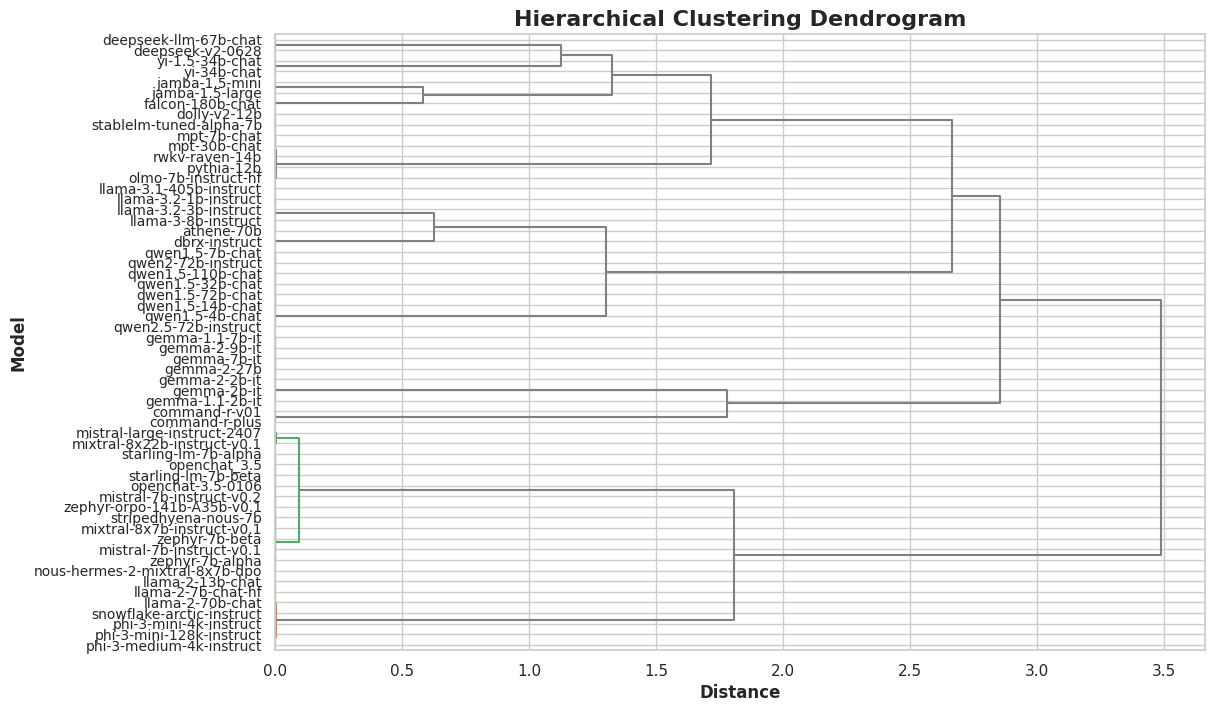

In [45]:
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="scipy.cluster.hierarchy")

linked = linkage(similarity_matrix, 'average')

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

dendrogram(linked,
           labels=model_names,
           leaf_rotation=0,
           leaf_font_size=10,
           orientation='right',
           color_threshold=0.5,
           above_threshold_color='gray',
           )


plt.title('Hierarchical Clustering Dendrogram', fontsize=16, weight='bold')
plt.xlabel('Distance', fontsize=12, weight='bold')
plt.ylabel('Model', fontsize=12, weight='bold')


plt.show()


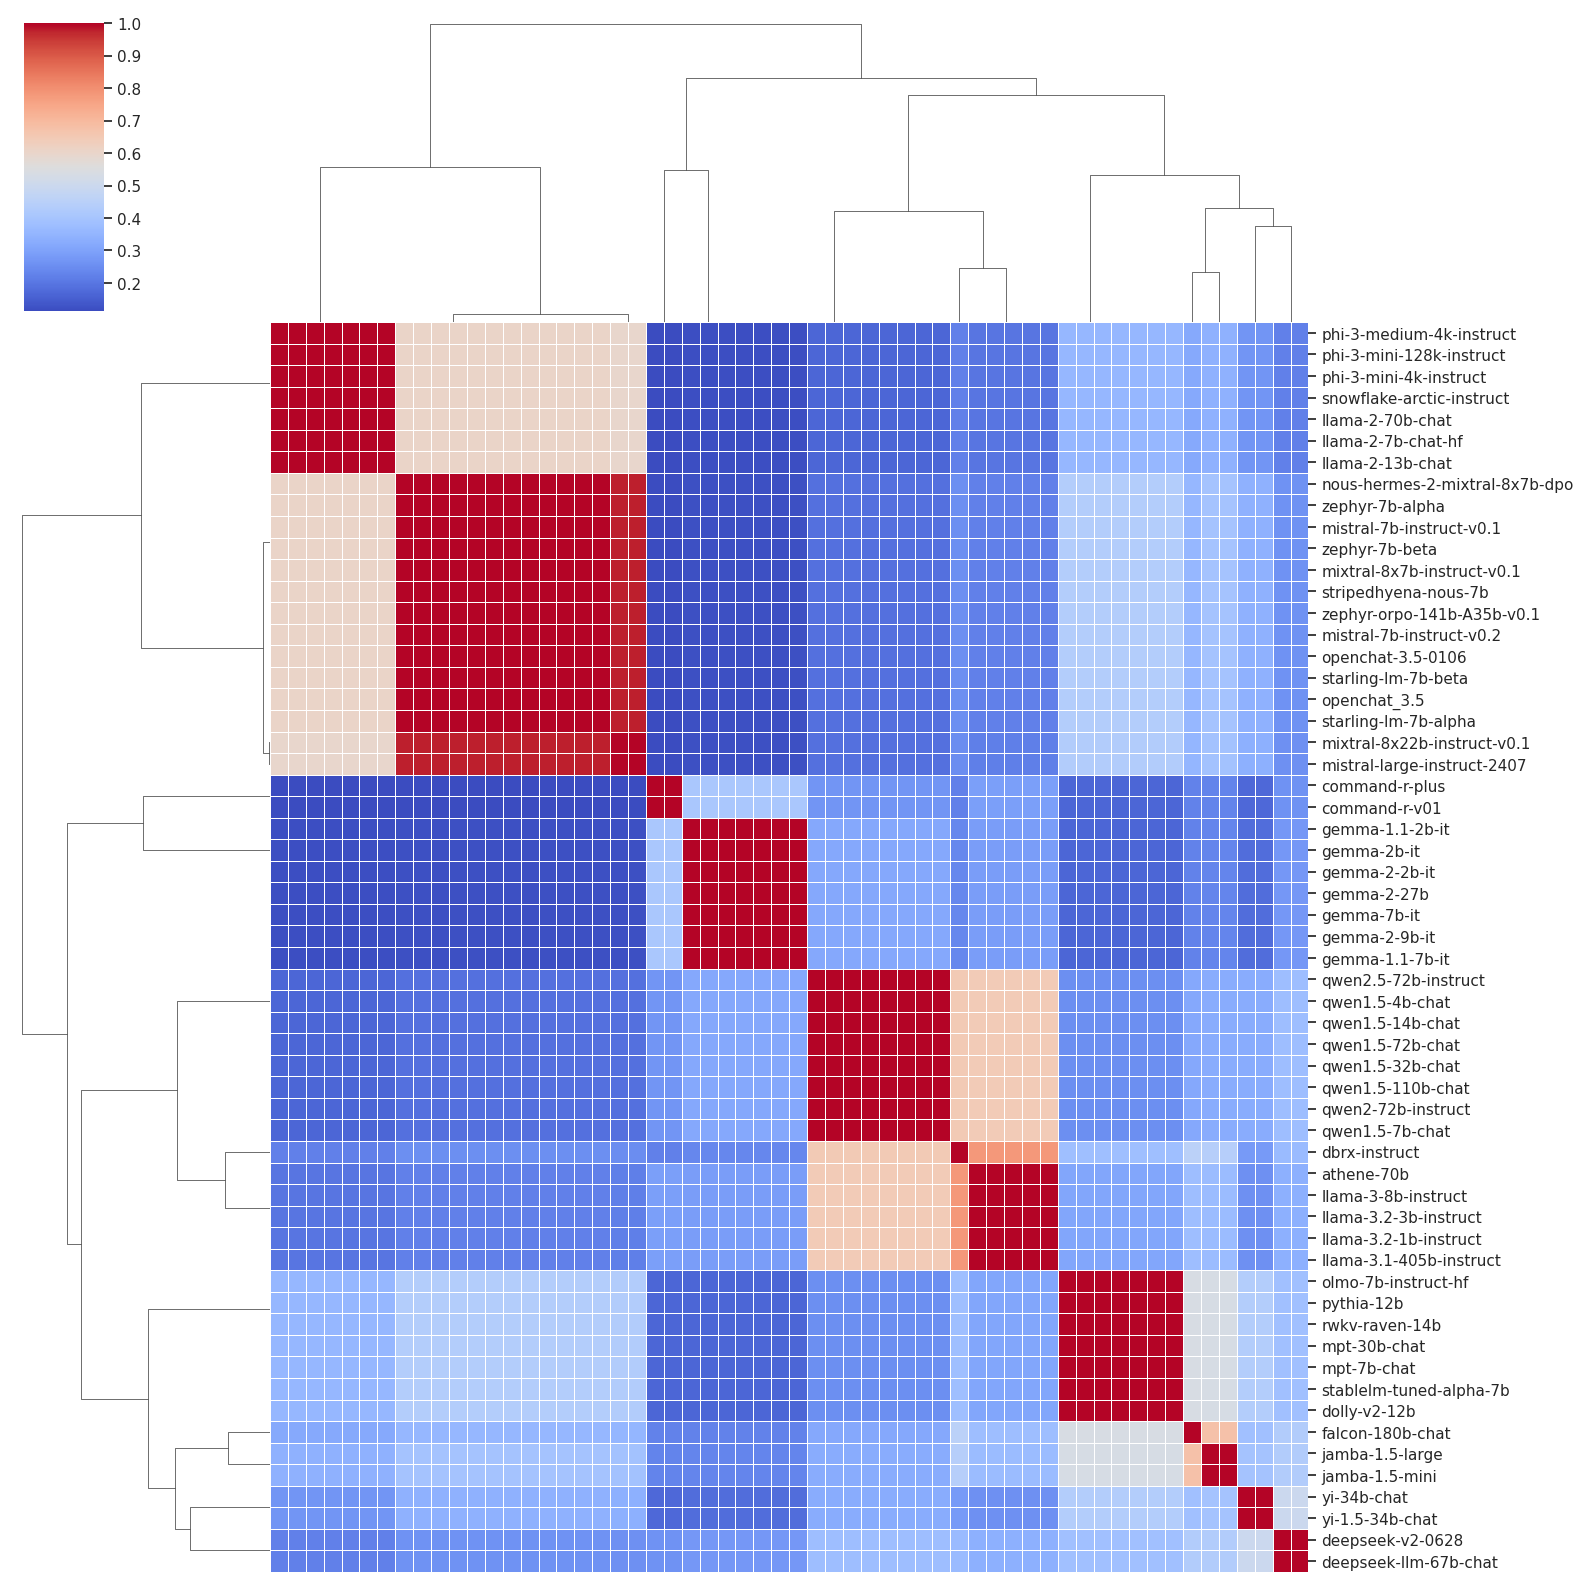

In [46]:
linked = linkage(similarity_matrix, 'average')

# Build a cluster map with model names
sns.clustermap(similarity_matrix,
               row_linkage=linked,  # Dendrogram for rows
               col_linkage=linked,  # Dendrogram for columns
               cmap='coolwarm',     # Color scheme
               linewidths=0.5,      # Line thickness between cells
               figsize=(16, 16),    # Figure size
               annot=False,         # Disable annotations inside cells
               xticklabels=False,
              #  xticklabels=model_names,  # Model names on the X-axis
               yticklabels=model_names)  # Model names on the Y-axis

# Set the title
# plt.title("Clustered Heatmap with Dendrogram", fontsize=16, weight='bold')

# Show the plot
plt.show()

In [47]:
same_tokenizers = [0] * num_models

cid = 1
for i in range(num_models):
    for j in range(i + 1, num_models):
        if similarity_matrix[i, j] > 0.95:
            if same_tokenizers[i] > 0:
              same_tokenizers[j] = same_tokenizers[i]
            elif same_tokenizers[j] > 0:
              same_tokenizers[i] = same_tokenizers[j]
            else:
              same_tokenizers[j] = cid
              same_tokenizers[i] = cid
              cid += 1
model_names = list(model2vocab.keys())
tokenizers_joined = {}
for i, mid in enumerate(same_tokenizers):
  tokenizers_joined.setdefault(mid, []).append(model_names[i])


In [48]:
key_tokenizers = {
    "llama-2": {
        "size": 31999,
        "models": ['phi-3-medium-4k-instruct', 'llama-2-70b-chat', 'llama-2-7b-chat-hf', 'snowflake-arctic-instruct', 'llama-2-13b-chat', 'phi-3-mini-128k-instruct', 'phi-3-mini-4k-instruct'],
    },
    "mistral": {
        "size": 32000,
        "models": ['openchat-3.5-0106', 'zephyr-7b-alpha', 'openchat_3.5', 'mistral-7b-instruct-v0.2', 'mixtral-8x22b-instruct-v0.1', 'mistral-large-instruct-2407', 'starling-lm-7b-beta', 'stripedhyena-nous-7b', 'zephyr-7b-beta', 'zephyr-orpo-141b-A35b-v0.1', 'mixtral-8x7b-instruct-v0.1', 'nous-hermes-2-mixtral-8x7b-dpo', 'starling-lm-7b-alpha', 'mistral-7b-instruct-v0.1'],
    },
    "mixtral": {
        "size": 32768,
        "models": ['mistral-large-instruct-2407', 'mixtral-8x22b-instruct-v0.1']
    },
    "pythia": {
        "size": 49790,
        "models": ['dolly-v2-12b', 'mpt-7b-chat', 'olmo-7b-instruct-hf', 'stablelm-tuned-alpha-7b', 'rwkv-raven-14b', 'pythia-12b', 'mpt-30b-chat'],
    },
    "yi-34b": {
        "size": 63985,
        "models": ['yi-1.5-34b-chat', 'yi-34b-chat'],
    },
    "falcon": {
        "size": 64456,
        "models": ['falcon-180b-chat'],
    },
    "jamba": {
        "size": 65536,
        "models": ['jamba-1.5-mini', 'jamba-1.5-large'],
    },
    "deepseek": {
        "size": 99467,
        "models": ['deepseek-v2-0628', 'deepseek-llm-67b-chat'],
    },
    "dbrx": {
        "size": 99579,
        "models": ['dbrx-instruct'],
    },
    "llama-3": {
        "size": 126784,
        "models": ['llama-3-8b-instruct', 'athene-70b', 'llama-3.1-405b-instruct'],
    },
    "qwen": {
        "size": 150307,
        "models": ['qwen2-72b-instruct', 'qwen1.5-14b-chat', 'qwen1.5-110b-chat', 'qwen1.5-4b-chat', 'qwen1.5-7b-chat', 'qwen1.5-72b-chat', 'qwen1.5-32b-chat'],
    },
    "command-r": {
        "size": 253266,
        "models": ['command-r-plus', 'command-r-v01'],
    },
    "gemma": {
        "size": 255999,
        "models": ['gemma-2-27b', 'gemma-2-9b-it', 'gemma-2b-it', 'gemma-7b-it', 'gemma-2-2b-it', 'gemma-1.1-7b-it', 'gemma-1.1-2b-it'],
    },
}


model2vocab_tok = {}
for i, (name, data) in enumerate(key_tokenizers.items()):
  d = (i+1, name, len(data["models"]), data["size"])
  print("\t".join(map(str, d)))
  model2vocab_tok[name] = model2vocab[data["models"][0]]



1	llama-2	7	31999
2	mistral	14	32000
3	mixtral	2	32768
4	pythia	7	49790
5	yi-34b	2	63985
6	falcon	1	64456
7	jamba	2	65536
8	deepseek	2	99467
9	dbrx	1	99579
10	llama-3	3	126784
11	qwen	7	150307
12	command-r	2	253266
13	gemma	7	255999


In [49]:
from collections import defaultdict
from tqdm import tqdm

token2hits_tok = defaultdict(lambda: [0] * len(model2vocab_tok))

for i, model in enumerate(tqdm(model2vocab_tok)):
  for token, rank in model2vocab_tok[model].items():
    token2hits_tok[token][i] = rank + 1


model_names_tok = list(model2vocab_tok.keys())
num_models = len(model_names_tok)

100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


In [50]:



similarity_matrix_tok = np.zeros((num_models, num_models))

for i, modela in enumerate(tqdm(model_names_tok)):
    for j, modelb in enumerate(model_names_tok):
        if i > j:
            continue
        a = set(model2vocab_tok[modela])
        b = set(model2vocab_tok[modelb])
        intersection = len(a.intersection(b))
        union = len(a) + len(b) - intersection
        if union > 0:
            weighted_jaccard = intersection / union
        else:
            weighted_jaccard = 0
        similarity_matrix_tok[i, j] = weighted_jaccard
        similarity_matrix_tok[j, i] = weighted_jaccard

100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


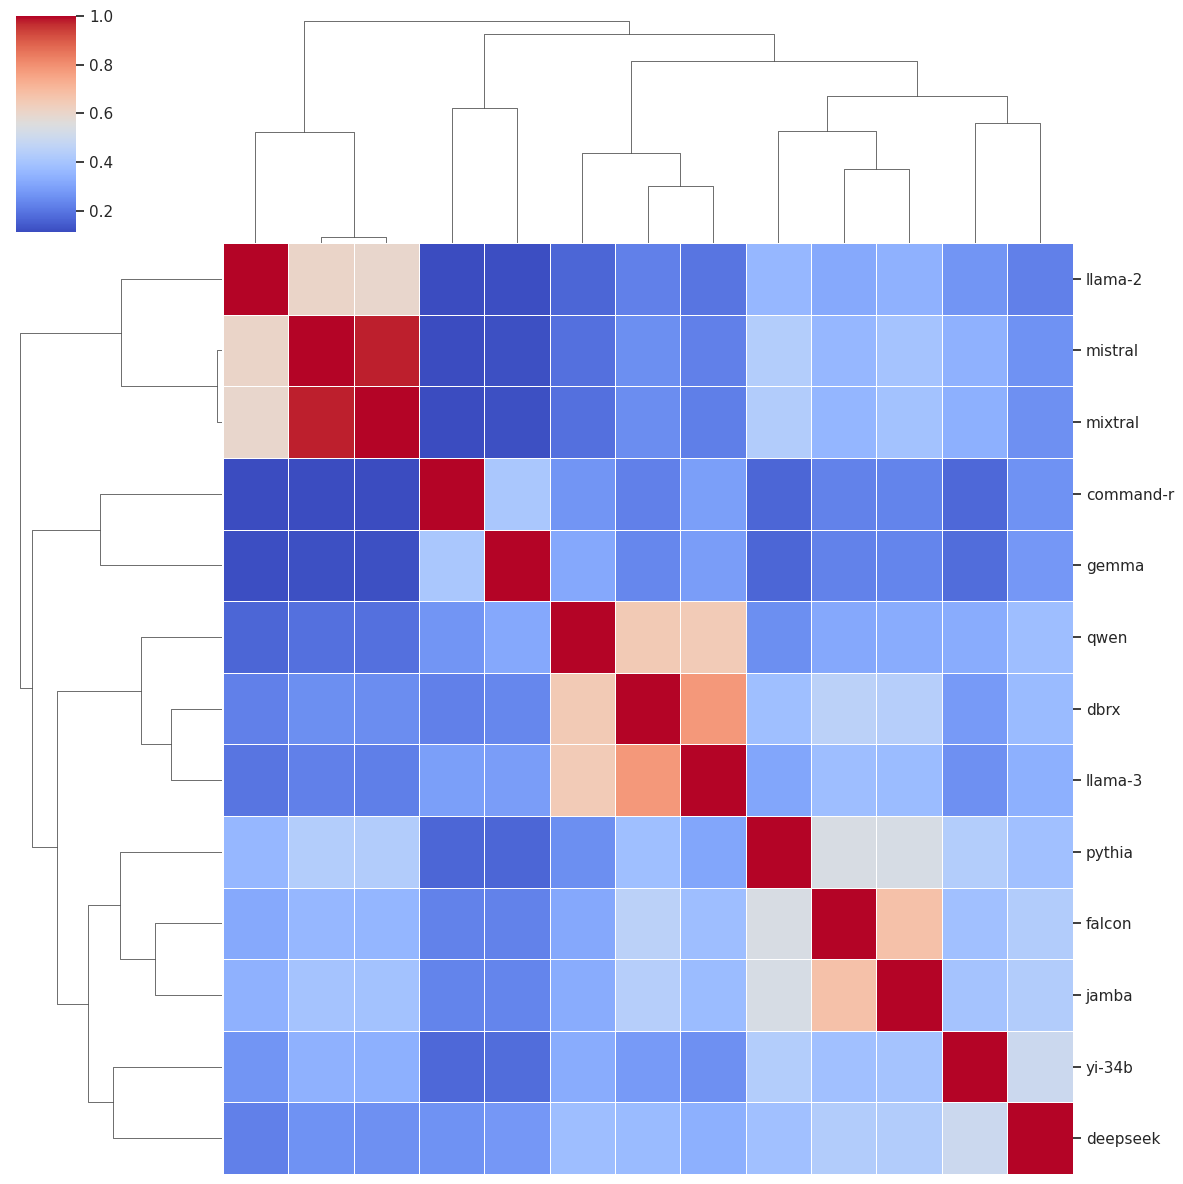

In [51]:
linked = linkage(similarity_matrix_tok, 'average')

sns.clustermap(similarity_matrix_tok,
               row_linkage=linked,
               col_linkage=linked,
               cmap='coolwarm',
               linewidths=0.5,
               figsize=(12, 12),
               annot=False,
               xticklabels=False,
               yticklabels=model_names_tok)

plt.show()


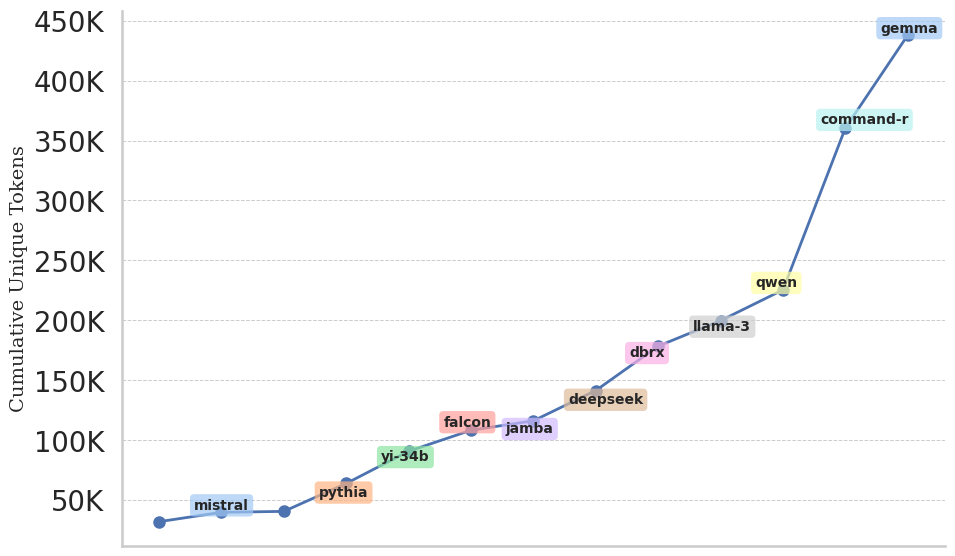

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import matplotlib.ticker as mtick

sns.set(style="whitegrid", context="talk", font_scale=1.2)

total_tokens = set()
cumulative_token_counts = []
model_order = []

for model_name, vocab in model2vocab_tok.items():
    total_tokens.update(vocab)
    cumulative_token_counts.append(len(total_tokens))
    model_order.append(model_name)

jumps = [i for i in range(1, len(cumulative_token_counts))
         if cumulative_token_counts[i] > cumulative_token_counts[i-1] + 1000]


colors = sns.color_palette("pastel", len(jumps))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_token_counts) + 1), cumulative_token_counts,
         marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

texts = []
for i, color in zip(jumps, colors):
    text = plt.text(i + 0.5, cumulative_token_counts[i], model_order[i], fontsize=10, ha='left', weight='bold',
                    bbox=dict(facecolor=color, edgecolor='none', alpha=0.7, boxstyle='round,pad=0.3'))  # Разные цвета
    texts.append(text)

adjust_text(texts)

plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.ylabel('Cumulative Unique Tokens', fontsize=14, family='serif')

plt.xticks([])

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

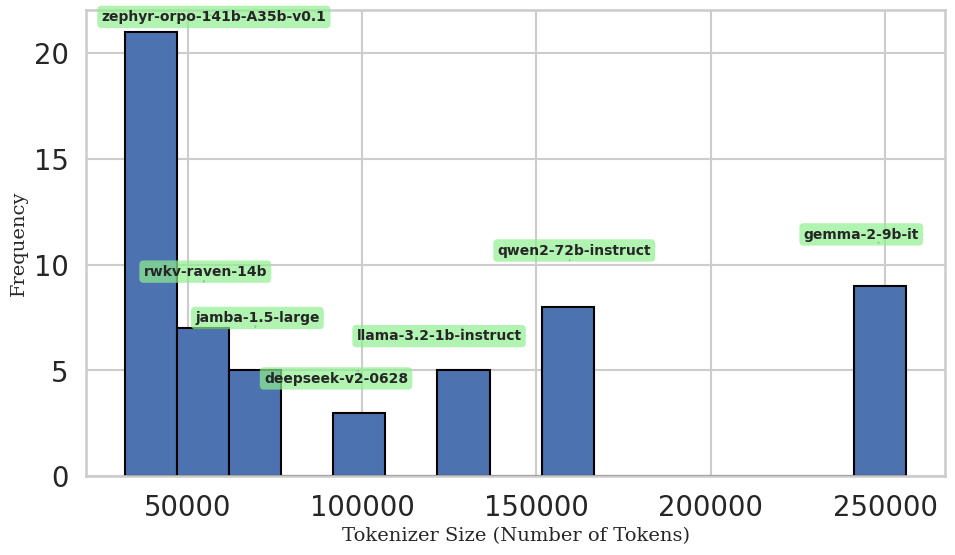

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

tokenizer_sizes = {model_name: len(vocab) for model_name, vocab in model2vocab.items()}

sns.set(style="whitegrid", context="talk", font_scale=1.2)

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(list(tokenizer_sizes.values()), bins=15, color='b', edgecolor='black')

texts = []
used_bins = set()

for model_name, size in tokenizer_sizes.items():
    try:
        bin_idx = next(i for i in range(len(bins) - 1) if bins[i] <= size < bins[i + 1])
    except StopIteration:
        bin_idx = len(bins) - 2

    if bin_idx not in used_bins:
        x = (bins[bin_idx] + bins[bin_idx + 1]) / 2
        y = counts[bin_idx]

        text = plt.text(x, y + 2, model_name, fontsize=10, ha='center', weight='bold',
                        bbox=dict(facecolor='lightgreen', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.3'))
        texts.append(text)
        used_bins.add(bin_idx)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1))

# plt.title('Distribution of Tokenizer Sizes with Model Names', fontsize=18, weight='bold', family='serif')
plt.xlabel('Tokenizer Size (Number of Tokens)', fontsize=14, family='serif')
plt.ylabel('Frequency', fontsize=14, family='serif')

plt.tight_layout()
plt.show()


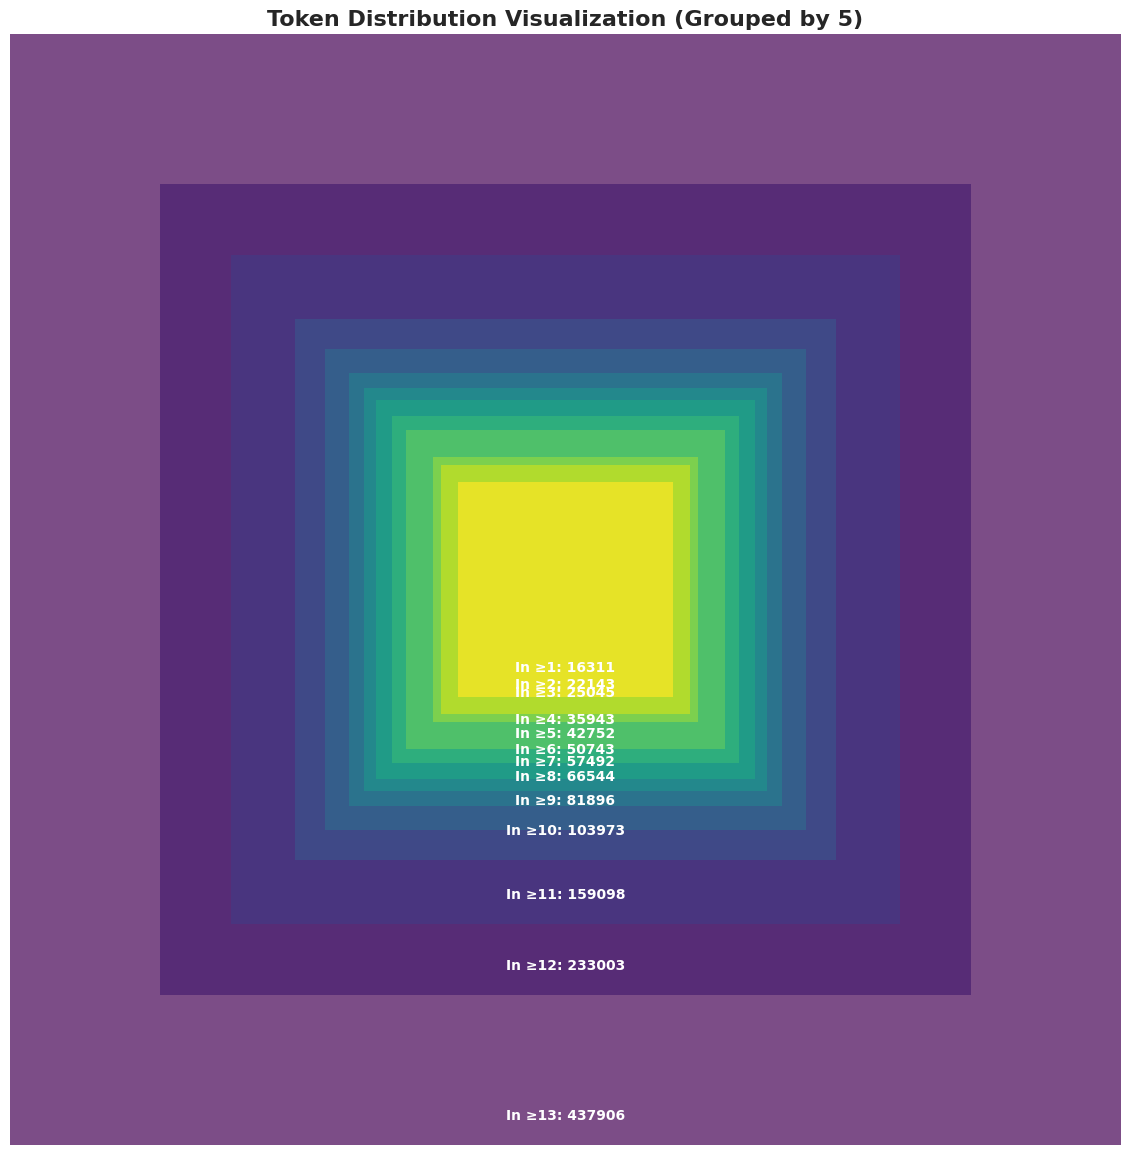

In [54]:
import matplotlib.pyplot as plt
import numpy as np

num_models = len(next(iter(token2hits_tok.values())))
token_counts = [0] * (num_models + 1)

for hits in token2hits_tok.values():
    count_present = sum(1 for hit in hits if hit > 0)
    token_counts[count_present] += 1

token_counts = token_counts[1:]


def create_nested_squares(token_counts, step=5):
    # Group data by step
    grouped_counts = [sum(token_counts[i:i+step]) for i in range(0, len(token_counts), step)]

    fig, ax = plt.subplots(figsize=(12, 12))

    # Calculate cumulative sums
    cumulative_sums = np.cumsum(grouped_counts[::-1])[::-1]

    # Calculate sizes based on square root of token counts
    sizes = np.sqrt(cumulative_sums)

    # Normalize sizes
    max_size = 1
    sizes = sizes / sizes[0] * max_size

    # Generate colors
    num_squares = len(grouped_counts)
    colors = plt.cm.viridis(np.linspace(0, 1, num_squares))

    # Create squares
    for i, size in enumerate(sizes):
        square = plt.Rectangle((0.5 - size/2, 0.5 - size/2), size, size,
                               fill=True, facecolor=colors[i], edgecolor='none', alpha=0.7)
        ax.add_patch(square)

    # Add labels
    for i, (count, size) in enumerate(zip(cumulative_sums, sizes)):
        lower_bound = num_squares * step - i * step
        upper_bound = lower_bound - step + 1
        label = f'In ≥{upper_bound}: {count}'
        ax.text(0.5, 0.5 - size/2 + 0.02, label,
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='white')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    plt.title('Token Distribution Visualization (Grouped by 5)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage
# Generate example data for 55 models

create_nested_squares(token_counts, step=1)

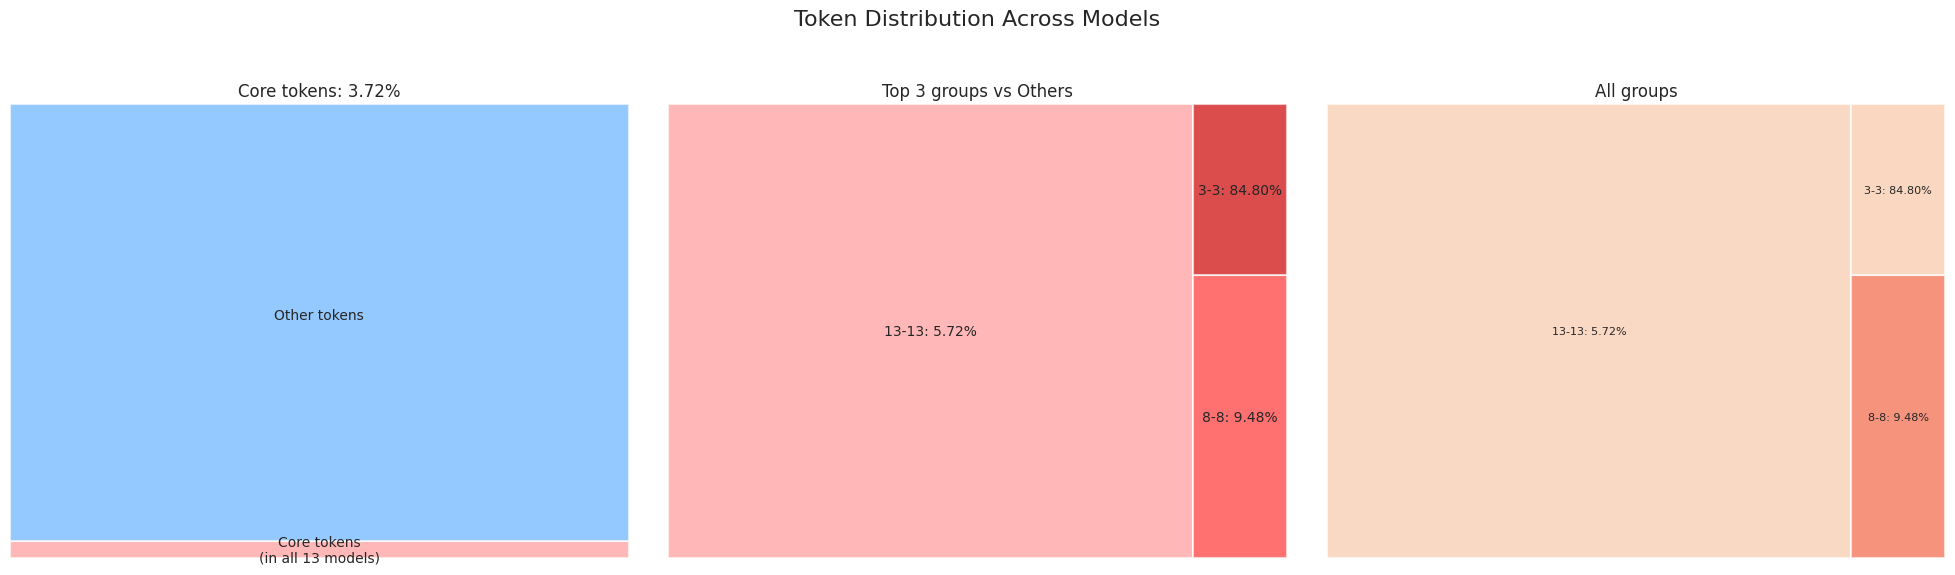

In [55]:
import matplotlib.pyplot as plt
import squarify
import numpy as np


def create_token_distribution_treemaps(token_counts, step=5):
    assert len(token_counts) == 13, "token_counts must contain exactly 13 elements"

    # Group data
    grouped_counts = [sum(token_counts[i:i+step]) for i in range(0, len(token_counts), step)]

    # Calculate total tokens and percentages
    total_tokens = sum(token_counts)

    # Check if total_tokens is zero to prevent ZeroDivisionError
    if total_tokens == 0:
        print("Error: total_tokens is zero. Cannot calculate percentages.")
        return

    percentages = [count / total_tokens * 100 for count in grouped_counts]

    # Prepare data for treemaps
    labels = [f'{13-i*5}-{13-i*5}: {p:.2f}%' for i, p in enumerate(percentages)]

    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Token Distribution Across Models', fontsize=16)

    # Treemap 1: Core tokens vs Others
    core_tokens = token_counts[-1]
    other_tokens = total_tokens - core_tokens
    squarify.plot([core_tokens, other_tokens],
                  label=['Core tokens\n(in all 13 models)', f'Other tokens\n'],
                  color=['#ff9999','#66b3ff'],
                  alpha=0.7,
                  text_kwargs={'fontsize':10, 'wrap':True},
                  ax=ax1)
    ax1.set_title(f'Core tokens: {core_tokens/total_tokens*100:.2f}%', fontsize=12)
    ax1.axis('off')

    # Treemap 2: Top 3 groups vs Others
    top_3 = grouped_counts[-3:]
    other = sum(grouped_counts[:-3])

    # Check if 'other' is zero and adjust data and labels accordingly
    if other == 0:
        data = top_3
        labels = [f'{13-i*5}-{13-i*5}: {count/total_tokens*100:.2f}%' for i, count in enumerate(reversed(top_3))]
    else:
        data = top_3 + [other]
        labels = [f'{13-i*5}-{13-i*5}: {count/total_tokens*100:.2f}%' for i, count in enumerate(reversed(top_3))] + ['Others']

    squarify.plot(data,
                  label=labels,
                  color=['#ff9999','#ff3333', '#cc0000', '#66b3ff'],
                  alpha=0.7,
                  text_kwargs={'fontsize':10, 'wrap':True},
                  ax=ax2)
    ax2.set_title('Top 3 groups vs Others', fontsize=12)
    ax2.axis('off')

    # Treemap 3: All groups
    squarify.plot(grouped_counts,
                  label=labels,
                  alpha=0.7,
                  text_kwargs={'fontsize':8, 'wrap':True},
                  ax=ax3)
    ax3.set_title('All groups', fontsize=12)
    ax3.axis('off')

    plt.tight_layout()
    plt.show()


create_token_distribution_treemaps(token_counts)

In [56]:
import unicodedata

### split to single chars, alphabetic+space, mixed, numbers
from collections import defaultdict

LANGUAGES = ['ADLAM', 'CHAKMA', 'OL', 'BAMUM', 'OGHAM', 'BOPOMOFO', 'COPTIC', 'RUNIC', 'HALFWIDTH',
                    'MODI', 'KAITHI', 'LEPCHA', 'SHAVIAN', 'LIMBU', 'BATAK', 'PHOENICIAN', 'GLAGOLITIC', 'MANDAIC', 'BALINESE', 'SAMARITAN', 'PHAGS-PA', 'OLD', 'BLACK-LETTER', 'SUNDANESE', 'INSCRIPTIONAL', 'LISU', 'CHAM', 'TAGALOG', 'DESERET', 'TAGBANWA',
                    'BUGINESE', 'THAANA', 'MONGOLIAN', 'DINGBAT', 'JAVANESE', 'EGYPTIAN', 'GEORGIAN', "NKO", 'TIFINAGH', "GURMUKHI", "BENGALI", "SINHALA", "ORIYA", "TAI", "KANGXI", 'CANADIAN', "CHEROKEE", "LAO", 'TELUGU', 'SYRIAC', "TAMIL", "BRAILLE", "ETHIOPIC", "MYANMAR", "HEBREW", "ARABIC", "TIBETAN", "HIRAGANA", "CYRILLIC", "GREEK", "CJK", "LATIN", "KATAKANA", "KHMER", 'THAI', 'ARMENIAN',
                    'YI', 'HANGUL', 'GOTHIC', 'MALAYALAM', 'DEVANAGARI', "GUJARATI", 'KANNADA', 'MEETEI', 'ARABIC-INDIC']

token2meta = {}
category2tokens = {
    # "numbers": defaultdict(list),
    "char": defaultdict(list),
    "spaced": defaultdict(list),
    "inner": defaultdict(list),
    "control_words": defaultdict(list),
    "pure_unicode": defaultdict(list),
    "unicode_flanks": defaultdict(list),
    "code": defaultdict(list),
    "control_token": defaultdict(list),
    "unicode_flanks": defaultdict(list),
}

for token in token2hits_tok:

  # if token.strip().isdigit():
  #   token2meta[token] = ("numbers", "numbers")
  #   if token[0] == ' ':
  #     category2tokens["numbers"]["spaced"].append(token)
  #   else:
  #     category2tokens["numbers"]["inner"].append(token)
  #   category2tokens["numbers"]["numbers"].append(token)
  #   continue

  if len(token) == 1:
    if token in char_to_byte:
      token2meta[token] = ("pure_unicode", "pure_unicode")
      category2tokens["pure_unicode"]["pure_unicode"].append(token)
      continue
    try:
      ut = [unicodedata.name(x).split() for x in token]
    except:
      token2meta[token] = ("char_errors",  "char_errors")
      category2tokens["char"]["errors"].append(token)
      continue
    if ut[0][0] in LANGUAGES:
      token2meta[token] = ("char_alpha",  ut[0][0])
      category2tokens["char"][("char_alpha",  ut[0][0])].append(token)
      continue
    else:
      token2meta[token] = ("char_other",  "char_other")
      category2tokens["char"]["other"].append(token)
      continue
  else:
    if token[0] == " ":
      try:
        ut = [unicodedata.name(x).split() for x in token]
      except:
        token2meta[token] = ("spaced_errors", "spaced_errors")
        category2tokens["spaced"]["errors"].append(token)
        continue
      hits = list(set([unicodedata.name(x).split()[0] for x in token[1:]]))
      if len(hits) == 1 and hits[0] in LANGUAGES:
        token2meta[token] = ("spaced_alpha", hits[0])
        category2tokens["spaced"][hits[0]].append(token)
      else:
        token2meta[token] = ("spaced_other","other")
        category2tokens["spaced"]["other"].append(token)
    else:
      if (token.startswith("<") and token.endswith(">") and not "<0y" in token) or ((token.startswith("[") and token.endswith("]"))):
        if not token[1:-1].lower().replace("/", "") in ["br", "h1", "h2", "h3", "h4", "h5", "h6", "b", "img", "li", "tr", "td", "p", "th", "u", "em"]:

          token2meta[token] = ("control_tokens","control_token")
          category2tokens["control_token"]["control_token"].append(token)
          continue
      if token.startswith("<0y"):
        token2meta[token] = ("unicode_flanks","unicode_flanks")
        category2tokens["unicode_flanks"]["unicode_flanks"].append(token)
        continue

      try:
        ut = [unicodedata.name(x).split() for x in token]
      except:
        token2meta[token] = ("inner_errors", "errors")
        category2tokens["inner"]["errors"].append(token)
        continue
      hits = list(set([unicodedata.name(x).split()[0] for x in token]))
      if len(hits) == 1 and hits[0] in LANGUAGES:
        token2meta[token] = ("inner_alpha", hits[0])
        category2tokens["inner"][hits[0]].append(token)
      else:
        token2meta[token] = ("inner_other", "other")
        category2tokens["inner"]["other"].append(token)


In [57]:
sample_cats = [
    ("char", "other"),
    ("char", "errors"),
    ("char", ('char_alpha', 'HEBREW')),
    ("char", ('char_alpha', 'GEORGIAN')),
    ("spaced", "other"),
    ("spaced", "errors"),
    ("spaced", "other"),
    ("spaced", "errors"),
    ("spaced", "LATIN"),
    ("spaced", "CYRILLIC"),
    ("spaced", "GREEK"),
    ("spaced", "CJK"),
    ("inner", "LATIN"),
    ("inner", "CYRILLIC"),
    ("inner", "GREEK"),
    ("inner", "CJK"),
    ("pure_unicode", "pure_unicode"),
("unicode_flanks", "unicode_flanks"),
("control_token", "control_token"),

]

In [58]:
import random

for cat1, cat2 in sample_cats:
  random_sample = random.sample(category2tokens[cat1][cat2], 5)
  print(cat1, cat2, random_sample)

char other ['🥝', '𝗗', '𝕯', '𝕪', '🦇']
char errors ['\ue823', '\ue095', '\uf8ef', '\ue04f', '\uf0ed']
char ('char_alpha', 'HEBREW') ['֪', 'ﬠ', 'ש', 'פּ', 'ײ']
char ('char_alpha', 'GEORGIAN') ['ო', 'ფ', 'ე', 'ტ', 'რ']
spaced other [' ボーダー', ' $$\\', ' })\\', ' .\\', ' [![']
spaced errors [' ${\n', ' ).\n\n', '                       \n', ' *);\n\n', ' ){\n']
spaced other [' 31', ' <<-', ' ± ', ' ---------------', ' 1978']
spaced errors [' `,\n', ' !=\n', ' "]");\n', ' ));\r\n', '    \t']
spaced LATIN [' Theorem', ' NRJ', ' pondered', ' çalışan', ' NIST']
spaced CYRILLIC [' степен', ' пекуляр', ' Харт', ' вироб', ' Йон']
spaced GREEK [' περιλαμβάνονται', ' ηλικία', ' αντίστοιχ', ' δού', ' αρισ']
spaced CJK [' 総', ' 題', ' 說', ' 合金', ' 輕']
inner LATIN ['ikopter', 'mester', 'zeption', 'motions', 'Werner']
inner CYRILLIC ['цыя', 'падает', 'зько', 'Вес', 'Фер']
inner GREEK ['εγέρ', 'λυ', 'φορία', 'νομή', 'ικής']
inner CJK ['舍得', '射箭', '作者的', '意见反馈', '分別是']
pure_unicode pure_unicode ['K', 'Ŀ', 'o'

In [59]:
for cat1 in category2tokens:
  for cat2 in category2tokens[cat1]:
    print(cat1, cat2)

char other
char ('char_alpha', 'CYRILLIC')
char errors
char ('char_alpha', 'LATIN')
char ('char_alpha', 'GREEK')
char ('char_alpha', 'ARABIC')
char ('char_alpha', 'HEBREW')
char ('char_alpha', 'HIRAGANA')
char ('char_alpha', 'KATAKANA')
char ('char_alpha', 'CJK')
char ('char_alpha', 'ARMENIAN')
char ('char_alpha', 'MALAYALAM')
char ('char_alpha', 'DEVANAGARI')
char ('char_alpha', 'GEORGIAN')
char ('char_alpha', 'THAI')
char ('char_alpha', 'TAMIL')
char ('char_alpha', 'HANGUL')
char ('char_alpha', 'TIBETAN')
char ('char_alpha', 'BENGALI')
char ('char_alpha', 'MYANMAR')
char ('char_alpha', 'BRAILLE')
char ('char_alpha', 'KHMER')
char ('char_alpha', 'GURMUKHI')
char ('char_alpha', 'SINHALA')
char ('char_alpha', 'SYRIAC')
char ('char_alpha', 'TIFINAGH')
char ('char_alpha', 'KANNADA')
char ('char_alpha', 'GUJARATI')
char ('char_alpha', 'NKO')
char ('char_alpha', 'TELUGU')
char ('char_alpha', 'LIMBU')
char ('char_alpha', 'ETHIOPIC')
char ('char_alpha', 'LAO')
char ('char_alpha', 'DINGBAT')
c

In [60]:

headers = [
    "control_tokens",
    # "numbers",
    "pure_unicode",
    "char_alpha",
    "spaced_alpha",
    "inner_alpha",

    "char_other",
    "spaced_other",
    "inner_other",

    "unicode_flanks",

    "char_errors",
    "spaced_errors",



    "inner_errors",
]
tokenizers_to_meta = {}


model = "Qtok"
tokenizers_to_meta[model] = defaultdict(int)
for token in token2hits_tok:
  meta = token2meta[token]
  if meta[0] in headers:
    tokenizers_to_meta[model][meta[0]] += 1
  else:
    print(meta)
    break

for model, tokens in model2vocab_tok.items():

  tokenizers_to_meta[model] = defaultdict(int)
  for token in tokens:
    meta = token2meta[token]
    if meta[0] in headers:
      tokenizers_to_meta[model][meta[0]] += 1
    else:
      print(meta)
      break

table = [
    ["Tokenizer"] + headers[::]
]
model = "Qtok"
table.append([model] + [0] * len(headers))
for i, header in enumerate(headers, start=1):
  table[-1][i] = tokenizers_to_meta[model][header]

for model in model2vocab_tok:
  table.append([model] + [0] * len(headers))
  for i, header in enumerate(headers, start=1):
    table[-1][i] = tokenizers_to_meta[model][header]

for line in table:
  print("\t".join(map(str, line)))

Tokenizer	control_tokens	pure_unicode	char_alpha	spaced_alpha	inner_alpha	char_other	spaced_other	inner_other	unicode_flanks	char_errors	spaced_errors	inner_errors
Qtok	2991	256	19166	196904	168797	4091	3617	30902	5885	916	827	3554
llama-2	16	256	1629	16054	12375	257	349	1039	0	13	5	18
mistral	8	256	2710	15425	11870	290	325	1001	0	67	11	39
mixtral	773	256	2710	15425	11870	290	325	1002	0	67	11	39
pythia	4	185	690	27288	17000	63	1463	2805	486	65	33	175
yi-34b	195	256	4204	23899	33550	107	344	1412	0	13	3	9
falcon	7	170	1194	39831	20581	58	53	2039	946	19	20	106
jamba	1549	256	2051	38996	20709	297	401	1176	0	42	13	46
deepseek	26	184	3660	46954	45059	113	711	2390	558	36	8	319
dbrx	33	184	1040	42603	28628	96	1190	22202	782	35	640	2847
llama-3	265	211	3597	55444	39084	210	1314	23131	1361	66	659	2914
qwen	15	256	14597	50981	54914	2915	1198	21791	1457	35	640	2847
command-r	48	198	5899	145978	92155	182	1121	4546	4489	33	92	288
gemma	151	255	15712	123481	102881	3841	1698	6728	0	913	81	289


In [61]:

headers = [
    "control_tokens",
    "pure_unicode",
    "char_alpha",
    "spaced_alpha",
    "inner_alpha",

    "char_other",
    "spaced_other",
    "inner_other",

    "unicode_flanks",

    "char_errors",
    "spaced_errors",



    "inner_errors",
]
tokenizers_to_meta = {}


model = "Qtok"
tokenizers_to_meta[model] = defaultdict(int)
for token in token2hits_tok:
  meta = token2meta[token]
  if meta[0] in headers:
    tokenizers_to_meta[model][meta[0]] += 1
  else:
    print(meta)
    break

for model, tokens in model2vocab_tok.items():

  tokenizers_to_meta[model] = defaultdict(int)
  for token in tokens:
    meta = token2meta[token]
    if meta[0] in headers:
      tokenizers_to_meta[model][meta[0]] += 1
    else:
      print(meta)
      break

table = [
    ["Tokenizer"] + headers[::]
]
model = "Qtok"
table.append([model] + [0] * len(headers))
for i, header in enumerate(headers, start=1):
  table[-1][i] = round(100.*tokenizers_to_meta[model][header]/len(token2meta), 2)

for model in model2vocab_tok:
  table.append([model] + [0] * len(headers))
  for i, header in enumerate(headers, start=1):
    table[-1][i] = round(100.*tokenizers_to_meta[model][header]/len(model2vocab_tok[model]), 2)

with open("table1.tsv", "w") as fw:
  for line in table:
    print("\t".join(map(str, line)))
    d = "\t".join(map(str, line))
    fw.write(f"{d}\n")



Tokenizer	control_tokens	pure_unicode	char_alpha	spaced_alpha	inner_alpha	char_other	spaced_other	inner_other	unicode_flanks	char_errors	spaced_errors	inner_errors
Qtok	0.68	0.06	4.38	44.96	38.55	0.93	0.83	7.06	1.34	0.21	0.19	0.81
llama-2	0.05	0.8	5.09	50.15	38.66	0.8	1.09	3.25	0.0	0.04	0.02	0.06
mistral	0.02	0.8	8.47	48.2	37.09	0.91	1.02	3.13	0.0	0.21	0.03	0.12
mixtral	2.36	0.78	8.27	47.07	36.22	0.89	0.99	3.06	0.0	0.2	0.03	0.12
pythia	0.01	0.37	1.37	54.3	33.83	0.13	2.91	5.58	0.97	0.13	0.07	0.35
yi-34b	0.3	0.4	6.57	37.35	52.43	0.17	0.54	2.21	0.0	0.02	0.0	0.01
falcon	0.01	0.26	1.84	61.26	31.65	0.09	0.08	3.14	1.45	0.03	0.03	0.16
jamba	2.36	0.39	3.13	59.5	31.6	0.45	0.61	1.79	0.0	0.06	0.02	0.07
deepseek	0.03	0.18	3.66	46.95	45.05	0.11	0.71	2.39	0.56	0.04	0.01	0.32
dbrx	0.03	0.18	1.04	42.48	28.55	0.1	1.19	22.14	0.78	0.03	0.64	2.84
llama-3	0.21	0.16	2.8	43.23	30.47	0.16	1.02	18.04	1.06	0.05	0.51	2.27
qwen	0.01	0.17	9.63	33.62	36.21	1.92	0.79	14.37	0.96	0.02	0.42	1.88
command-r	0.02	0.08	2.31

In [62]:
from collections import defaultdict

headers = []
tokenizers_to_meta = {}

model = "Qtok"
tokenizers_to_meta[model] = defaultdict(int)

for token in token2hits_tok:
    meta = token2meta[token]
    if not "alpha" in meta[0]:
        continue
    lang = meta[1]
    tokenizers_to_meta[model][meta] += 1

headers = list(tokenizers_to_meta[model].keys())

for model, tokens in model2vocab_tok.items():
    tokenizers_to_meta[model] = defaultdict(int)
    for token in tokens:
        meta = token2meta[token]
        if not "alpha" in meta[0]:
            continue
        lang = meta[1]
        tokenizers_to_meta[model][meta] += 1

table = [
    ["Tokenizer"] + headers[::]
]

model = "Qtok"
table.append([model] + [0] * len(headers))
for i, header in enumerate(headers, start=1):
    table[-1][i] = round(100.*tokenizers_to_meta[model][header]/len(token2meta), 2)

for model in model2vocab_tok:
    table.append([model] + [0] * len(headers))
    for i, header in enumerate(headers, start=1):
        table[-1][i] = round(100.*tokenizers_to_meta[model][header]/len(model2vocab_tok[model]), 2)

transposed_table = list(zip(*table))

def format_header(header_tuple):
    return f"{header_tuple[1]} ({header_tuple[0].replace('_alpha', '')})"

formatted_table = [[format_header(row[0])] + list(row[1:]) if isinstance(row[0], tuple) else list(row) for row in transposed_table]

other_row = ['Other'] + [0] * (len(formatted_table[0]) - 1)
final_table = [formatted_table[0]]

for row in formatted_table[1:]:
    if all(float(cell) <= 1 for cell in row[1:]):
        for i in range(1, len(row)):
            other_row[i] += float(row[i])
    else:
        final_table.append(row)

other_row = [other_row[0]] + [round(val, 2) for val in other_row[1:]]

if any(other_row[1:]):
    final_table.append(other_row)

final_table = list(zip(*final_table))

with open("table2.tsv", "w") as fw:
  for line in final_table:
    print("\t".join(map(str, line)))
    d = "\t".join(map(str, line))
    fw.write(f"{d}\n")


Tokenizer	LATIN (spaced)	LATIN (inner)	CYRILLIC (inner)	CYRILLIC (spaced)	ARABIC (inner)	GREEK (spaced)	ARABIC (spaced)	GREEK (inner)	CJK (char)	HANGUL (char)	CJK (inner)	HEBREW (inner)	HANGUL (spaced)	THAI (inner)	Other
Qtok	34.98	24.01	3.05	5.03	1.02	1.03	1.26	0.73	2.67	0.61	6.57	0.53	0.94	0.72	4.71
llama-2	45.62	34.28	4.38	4.53	0.0	0.0	0.0	0.0	2.19	0.35	0.0	0.0	0.0	0.0	2.54
mistral	45.91	34.28	2.8	2.28	0.0	0.0	0.01	0.0	4.55	1.08	0.01	0.0	0.0	0.0	2.83
mixtral	44.84	33.48	2.73	2.23	0.0	0.0	0.01	0.0	4.44	1.06	0.01	0.0	0.0	0.0	2.77
pythia	53.86	33.04	0.44	0.22	0.04	0.13	0.06	0.16	0.6	0.04	0.02	0.0	0.0	0.0	0.86
yi-34b	36.5	24.47	0.97	0.73	0.0	0.0	0.0	0.0	6.28	0.04	26.98	0.0	0.0	0.0	0.35
falcon	61.23	31.06	0.03	0.02	0.0	0.01	0.0	0.0	1.65	0.0	0.57	0.0	0.0	0.0	0.17
jamba	58.35	30.15	0.12	0.06	0.67	0.01	0.54	0.0	1.69	0.46	0.08	0.57	0.01	0.0	1.51
deepseek	42.56	27.68	2.75	4.35	0.01	0.02	0.01	0.03	3.42	0.01	14.58	0.0	0.0	0.0	0.21
dbrx	41.94	27.83	0.4	0.27	0.03	0.01	0.03	0.0	0.55	0.13	0.2	0.0	0

In [63]:
!cat './table1.tsv'

Tokenizer	control_tokens	pure_unicode	char_alpha	spaced_alpha	inner_alpha	char_other	spaced_other	inner_other	unicode_flanks	char_errors	spaced_errors	inner_errors
Qtok	0.68	0.06	4.38	44.96	38.55	0.93	0.83	7.06	1.34	0.21	0.19	0.81
llama-2	0.05	0.8	5.09	50.15	38.66	0.8	1.09	3.25	0.0	0.04	0.02	0.06
mistral	0.02	0.8	8.47	48.2	37.09	0.91	1.02	3.13	0.0	0.21	0.03	0.12
mixtral	2.36	0.78	8.27	47.07	36.22	0.89	0.99	3.06	0.0	0.2	0.03	0.12
pythia	0.01	0.37	1.37	54.3	33.83	0.13	2.91	5.58	0.97	0.13	0.07	0.35
yi-34b	0.3	0.4	6.57	37.35	52.43	0.17	0.54	2.21	0.0	0.02	0.0	0.01
falcon	0.01	0.26	1.84	61.26	31.65	0.09	0.08	3.14	1.45	0.03	0.03	0.16
jamba	2.36	0.39	3.13	59.5	31.6	0.45	0.61	1.79	0.0	0.06	0.02	0.07
deepseek	0.03	0.18	3.66	46.95	45.05	0.11	0.71	2.39	0.56	0.04	0.01	0.32
dbrx	0.03	0.18	1.04	42.48	28.55	0.1	1.19	22.14	0.78	0.03	0.64	2.84
llama-3	0.21	0.16	2.8	43.23	30.47	0.16	1.02	18.04	1.06	0.05	0.51	2.27
qwen	0.01	0.17	9.63	33.62	36.21	1.92	0.79	14.37	0.96	0.02	0.42	1.88
command-r	0.02	0.08	2.31

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_with_distinct_markers_and_colors(file_path_new):
    data_normalized = pd.read_csv(file_path_new, sep="\t")
    # Prepare parameter names (replace underscores with spaces)
    parameters = [param.replace('_', ' ') for param in data_normalized.columns[1:]]  # Replacing underscores with spaces
    x = np.arange(len(parameters))  # Parameters on the X-axis
    fig, ax = plt.subplots(figsize=(15, 10))  # Enlarged figure size for better readability

    # Get unique tokenizers
    tokenizers = data_normalized['Tokenizer'].unique()
    num_tokenizers = len(tokenizers)

    # Define a list of 14 distinguishable colors (color-blind friendly)
    colors = [
        '#5da3ce',  # moderate blue
        '#ffa347',  # moderate orange
        '#6fbf58',  # moderate green
        '#e77f80',  # moderate red
        '#b28ac9',  # moderate purple
        '#aa7c70',  # moderate brown
        '#ec9ad3',  # moderate pink
        '#a6a6a6',  # moderate gray
        '#cece58',  # moderate olive
        '#5ad0dc',  # moderate turquoise
        '#6b6da1',  # moderate dark blue
        '#82996a',  # moderate dark green
        '#b69b5d',  # moderate dark brown
        '#ab5e5c',  # moderate dark red
    ]

    # Define a list of 14 distinguishable markers
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>', 'h', 'd', '8', 'H']

    # Check if there are enough colors and markers
    if num_tokenizers > len(colors):
        raise ValueError(f"Number of tokenizers ({num_tokenizers}) exceeds the number of available colors ({len(colors)}). Please add more colors.")
    if num_tokenizers > len(markers):
        raise ValueError(f"Number of tokenizers ({num_tokenizers}) exceeds the number of available markers ({len(markers)}). Please add more markers.")

    # Assign unique color and marker to each tokenizer
    tokenizer_styles = {}
    for i, tokenizer in enumerate(tokenizers):
        tokenizer_styles[tokenizer] = {
            'color': colors[i],
            'marker': markers[i],
            'label': tokenizer
        }

    # Plot lines for each tokenizer
    for tokenizer in tokenizers:
        values = data_normalized[data_normalized['Tokenizer'] == tokenizer].values[0][1:]
        std_dev = np.std(values) / np.sqrt(len(values))  # Approximation for confidence intervals
        style = tokenizer_styles[tokenizer]

        ax.errorbar(
            x,
            values,
            # yerr=std_dev,  # Uncomment this line to add error bars
            fmt=style['marker'],
            color=style['color'],
            capsize=5,
            label=style['label'],
            markersize=8  # Increased marker size for better visibility
        )

    # Set X-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(parameters, rotation=45, ha="right")

    ax.set_ylabel("Normalized Value (%)")  # Label for Y-axis with percentages

    # Check if tokenizer 'Qtok' is present
    if 'Qtok' in tokenizers:
        joined_data = data_normalized[data_normalized['Tokenizer'] == 'Qtok'].values[0][1:]

        # Add special style for 'Qtok' tokenizer
        tokenizer_styles['Qtok'] = {
            'color': '#a6cee3',  # Pastel blue color for the marker
            'marker': 'o',
            'label': 'Qtok'
        }

        # Display 'Qtok' as a special marker on the plot
        for i, (xi, yi) in enumerate(zip(x, joined_data)):
            ax.plot(xi, yi, marker='o', markersize=12, markeredgecolor='black',
                    markerfacecolor='#a6cee3', linestyle='None', zorder=12)

    # Configure the legend
    handles, labels = ax.get_legend_handles_labels()

    # Add special marker 'Qtok' to the legend
    if 'Qtok' in tokenizer_styles:
        joined_style = tokenizer_styles['Qtok']
        joined_marker = plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=joined_style['color'],
                                   markeredgecolor='black', markersize=12, label=joined_style['label'])
        handles.append(joined_marker)
        labels.append('Qtok')

    handles = handles[1:]
    labels = labels[1:]

    # Display the updated legend
    ax.legend(handles=handles, labels=labels, title='Tokenizer', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format Y-axis values without percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

    plt.tight_layout()
    plt.show()



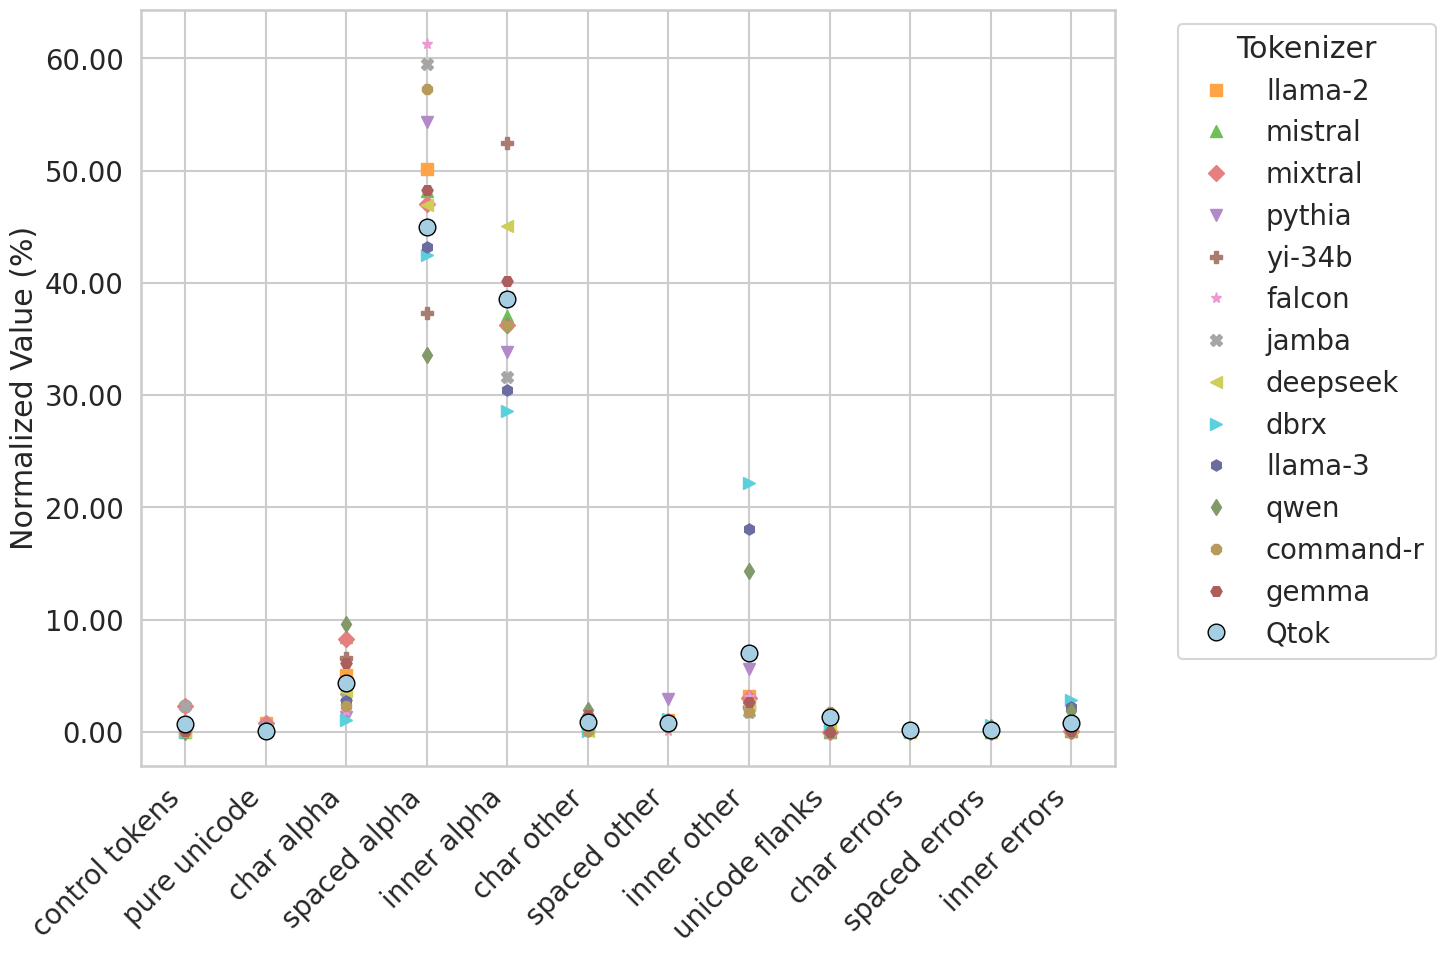

In [73]:
file_path_new = './table1.tsv'
# Call the function to plot with distinct markers and colors
plot_with_distinct_markers_and_colors(file_path_new)

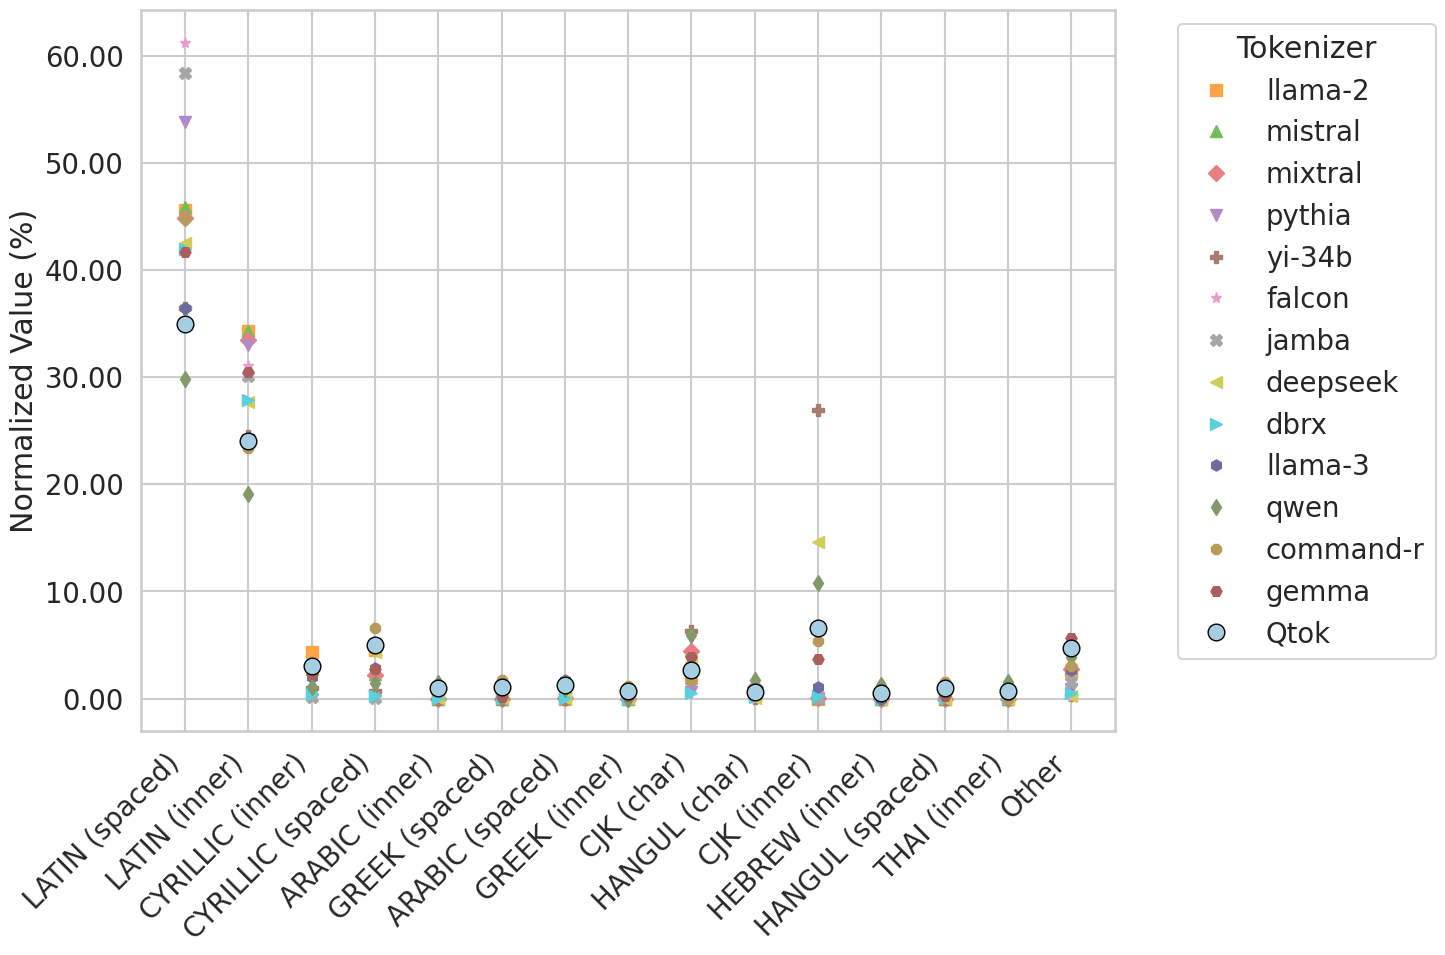

In [74]:
file_path_new = './table2.tsv'
# Call the function to plot with distinct markers and colors
plot_with_distinct_markers_and_colors(file_path_new)

In [66]:
with open("only_lat.tokens", "w") as fw:
  for token, (a, b) in token2meta.items():
    if "LATIN" in b and len(token) > 1 and "alpha" in a:
      fw.write(f"{token}\n")
with open("only_cyr.tokens", "w") as fw:
  for token, (a, b) in token2meta.items():
    if "CYR" in b and len(token) > 1 and "alpha" in a:
      fw.write(f"{token}\n")


In [67]:
with open("./Qtok/src/qtok/data/tokens2natural_lat.json") as fh:
  lat_data = json.load(fh)
with open("./Qtok/src/qtok/data/tokens2natural_cyr.json") as fh:
  cyr_data = json.load(fh)

In [76]:
from collections import defaultdict

# Initial data
headers = []
tokenizers_to_meta = {}

model = "Qtok"
tokenizers_to_meta[model] = defaultdict(int)
model2size = defaultdict(int)

# Preparing metadata
for token in token2hits_tok:
    meta = token2meta[token]
    if not "alpha" in meta[0]:
        continue
    if not token in lat_data:
        continue
    for lang in lat_data[token]:
        tokenizers_to_meta[model][lang] += 1/len(lat_data[token])
        model2size[model] += 1

headers = list(tokenizers_to_meta[model].keys())

# Gathering information for all models
for model, tokens in model2vocab_tok.items():
    tokenizers_to_meta[model] = defaultdict(int)
    for token in tokens:
        meta = token2meta[token]
        if not "alpha" in meta[0]:
            continue
        if not token in lat_data:
            continue
        for lang in lat_data[token]:
            tokenizers_to_meta[model][lang] += 1/len(lat_data[token])
            model2size[model] += 1

# Creating the table
table = [
    ["Tokenizer"] + headers[::]
]

# Adding data for the "Qtok" model
model = "Qtok"
table.append([model] + [0] * len(headers))
for i, header in enumerate(headers, start=1):
    table[-1][i] = round(100. * tokenizers_to_meta[model][header] / model2size[model], 2)

# Adding data for all models
for model in model2vocab_tok:
    table.append([model] + [0] * len(headers))
    for i, header in enumerate(headers, start=1):
        table[-1][i] = round(100. * tokenizers_to_meta[model][header] / model2size[model], 2)

# Transposing the table
transposed_table = list(zip(*table))

# Converting row headers
def format_header(header_tuple):
    return f"{header_tuple[1]} ({header_tuple[0].replace('_alpha', '')})"

# Updating row headers (if not the first row)
formatted_table = [[format_header(row[0])] + list(row[1:]) if isinstance(row[0], tuple) else list(row) for row in transposed_table]

# Now we need to iterate over the transposed table and combine rows with values <= 1%
other_row = ['Other'] + [0] * (len(formatted_table[0]) - 1)
final_table = [formatted_table[0]]  # First row with headers

for row in formatted_table[1:]:
    # Check if all values in the row are <= 1
    if all(float(cell) <= 0.5 for cell in row[1:]):
        # If yes, sum them into the 'Other' row
        for i in range(1, len(row)):
            other_row[i] += float(row[i])
    else:
        # If there are values > 1, keep the row
        final_table.append(row)

# Rounding values in the 'Other' row to two decimal places
other_row = [other_row[0]] + [round(val, 2) for val in other_row[1:]]

# Add the 'Other' row if there are rows to combine
if any(other_row[1:]):  # Check if there is anything besides the header
    final_table.append(other_row)

final_table = list(zip(*final_table))

# Output the final table (do not transpose it back)
with open("table3.tsv", "w") as fw:
    for line in final_table:
        print("\t".join(map(str, line)))
        d = "\t".join(map(str, line))
        fw.write(f"{d}\n")

Tokenizer	en	es	fr	it	de	hu	nl	pt	sv	pl	sk	cs	fi	et	tr	ro	Other
Qtok	25.26	6.64	2.39	1.18	9.78	0.77	0.77	0.83	0.5	1.37	0.51	0.85	0.58	0.56	0.72	0.58	3.03
llama-2	20.92	6.65	1.94	0.58	10.0	0.46	0.42	0.33	0.31	0.49	0.27	0.31	0.32	0.33	0.12	0.17	1.25
mistral	23.72	6.66	1.63	0.55	9.88	0.23	0.35	0.24	0.2	0.29	0.14	0.18	0.29	0.31	0.08	0.15	1.0
mixtral	23.72	6.66	1.63	0.55	9.88	0.23	0.35	0.24	0.2	0.29	0.14	0.18	0.29	0.31	0.08	0.15	1.0
pythia	28.76	6.63	1.55	0.69	9.85	0.15	0.38	0.23	0.26	0.28	0.09	0.13	0.35	0.37	0.06	0.21	1.07
yi-34b	29.98	6.5	1.47	0.62	10.1	0.08	0.33	0.16	0.21	0.25	0.05	0.09	0.29	0.33	0.05	0.18	0.94
falcon	27.75	6.47	1.93	0.87	10.12	0.26	0.53	0.32	0.35	0.52	0.19	0.26	0.44	0.41	0.07	0.25	1.35
jamba	27.92	6.95	2.14	0.81	9.86	0.34	0.54	0.66	0.26	0.32	0.16	0.25	0.38	0.39	0.09	0.22	1.27
deepseek	30.97	7.3	1.5	0.88	10.04	0.1	0.38	0.29	0.24	0.33	0.08	0.11	0.36	0.41	0.07	0.23	1.17
dbrx	30.24	6.49	1.56	0.7	9.83	0.2	0.42	0.32	0.27	0.37	0.11	0.16	0.37	0.38	0.11	0.2	1.27
llama-3	27.42	6.

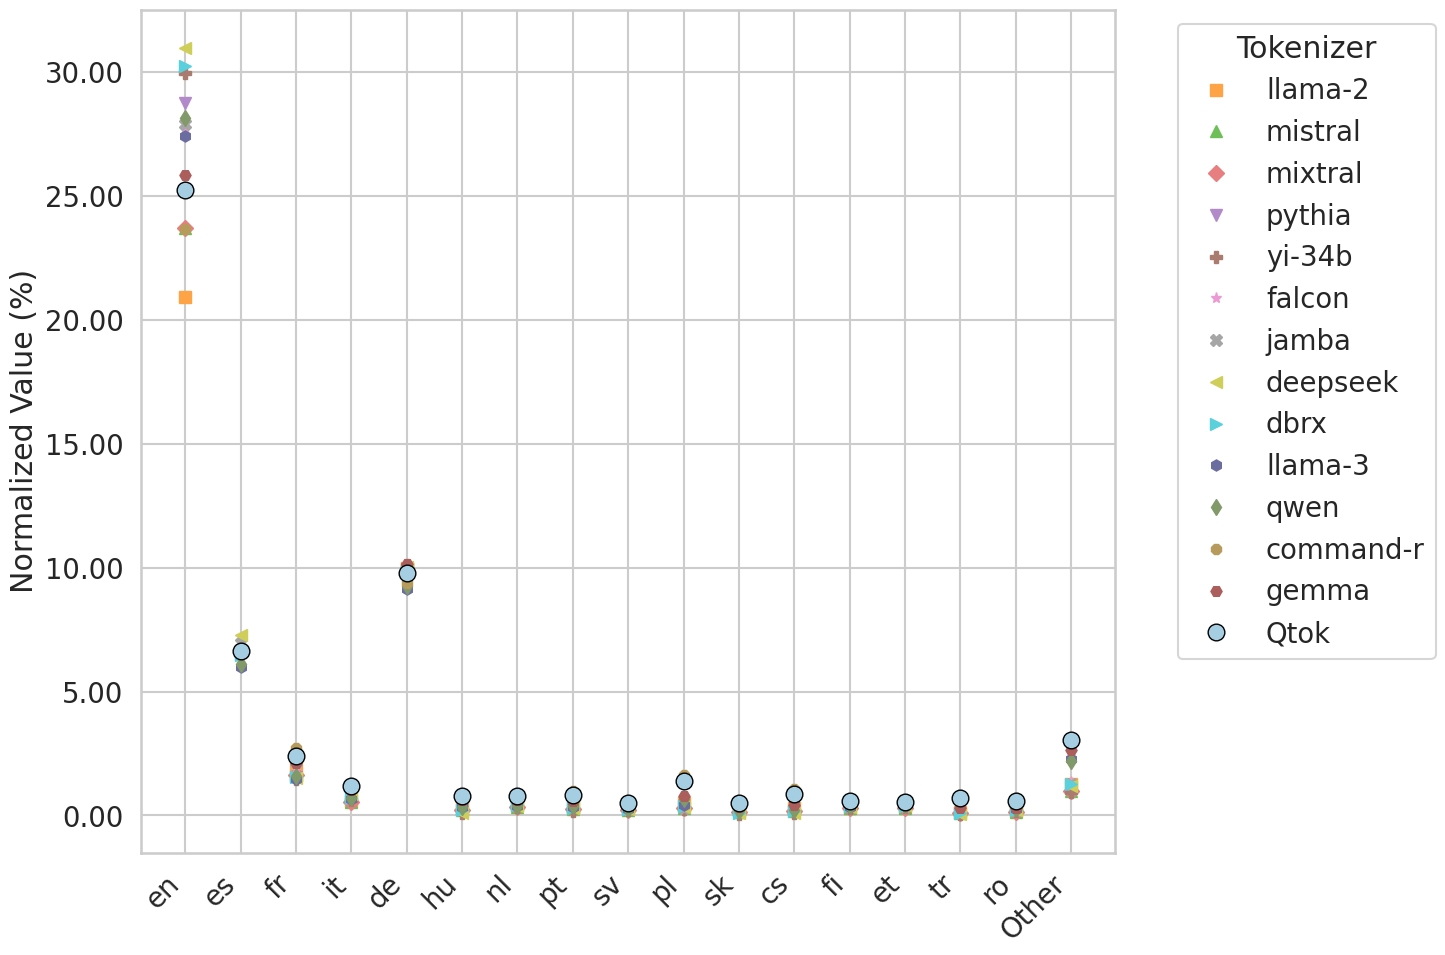

In [75]:
file_path_new = './table3.tsv'
# Call the function to plot with distinct markers and colors
plot_with_distinct_markers_and_colors(file_path_new)

In [77]:
from collections import defaultdict

headers = []
tokenizers_to_meta = {}

model = "Qtok"
tokenizers_to_meta[model] = defaultdict(int)
model2size = defaultdict(int)
for token in token2hits_tok:
    meta = token2meta[token]
    if not "alpha" in meta[0]:
        continue
    if not token in cyr_data:
      continue
    for lang in cyr_data[token]:
      tokenizers_to_meta[model][lang] += 1/len(cyr_data[token])
      model2size[model] += 1

headers = list(tokenizers_to_meta[model].keys())



for model, tokens in model2vocab_tok.items():
    tokenizers_to_meta[model] = defaultdict(int)
    for token in tokens:
        meta = token2meta[token]
        if not "alpha" in meta[0]:
            continue
        if not token in cyr_data:
          continue
        for lang in cyr_data[token]:
          tokenizers_to_meta[model][lang] += 1/len(cyr_data[token])
          model2size[model] += 1

table = [
    ["Tokenizer"] + headers[::]
]

model = "Qtok"
table.append([model] + [0] * len(headers))
for i, header in enumerate(headers, start=1):
    table[-1][i] = round(100.*tokenizers_to_meta[model][header]/model2size[model], 2)

for model in model2vocab_tok:
    table.append([model] + [0] * len(headers))
    for i, header in enumerate(headers, start=1):
        table[-1][i] = round(100.*tokenizers_to_meta[model][header]/model2size[model], 2)

transposed_table = list(zip(*table))

def format_header(header_tuple):
    return f"{header_tuple[1]} ({header_tuple[0].replace('_alpha', '')})"

formatted_table = [[format_header(row[0])] + list(row[1:]) if isinstance(row[0], tuple) else list(row) for row in transposed_table]

other_row = ['Other'] + [0] * (len(formatted_table[0]) - 1)
final_table = [formatted_table[0]]  # Первая строка с заголовками

for row in formatted_table[1:]:
    if all(float(cell) <= 0.5 for cell in row[1:]):
        for i in range(1, len(row)):
            other_row[i] += float(row[i])
    else:
        final_table.append(row)

other_row = [other_row[0]] + [round(val, 2) for val in other_row[1:]]

if any(other_row[1:]):
    final_table.append(other_row)

final_table = list(zip(*final_table))

with open("table4.tsv", "w") as fw:
  for line in final_table:
    print("\t".join(map(str, line)))
    d = "\t".join(map(str, line))
    fw.write(f"{d}\n")


Tokenizer	uk	bg	ru	be	sr	mk	mn	kk	Other
Qtok	7.88	7.99	19.09	3.82	4.05	1.4	1.83	2.4	0.19
llama-2	6.06	6.23	11.48	2.74	3.64	1.29	1.42	1.62	0.18
mistral	5.53	6.11	10.1	2.37	3.38	1.31	1.39	1.46	0.17
mixtral	5.53	6.11	10.1	2.37	3.38	1.31	1.39	1.46	0.17
pythia	4.54	5.63	7.14	2.02	3.58	1.52	1.0	1.02	0.16
yi-34b	4.24	8.32	9.41	1.59	3.94	1.73	1.28	1.17	0.19
falcon	4.19	4.92	5.38	1.65	3.73	1.59	0.0	1.35	0.2
jamba	4.28	5.12	6.18	2.1	3.67	1.47	0.94	1.16	0.04
deepseek	4.82	12.61	13.75	2.04	4.39	2.1	1.65	1.78	0.15
dbrx	5.16	6.08	9.84	2.57	3.84	1.33	1.03	1.63	0.12
llama-3	8.0	6.3	13.42	3.35	3.66	1.05	1.44	1.81	0.17
qwen	5.76	7.4	15.69	2.97	3.78	1.27	1.55	1.89	0.16
command-r	8.67	6.75	20.08	4.19	3.91	1.16	1.86	2.52	0.18
gemma	6.32	7.13	16.43	3.22	4.0	1.39	1.66	2.16	0.21


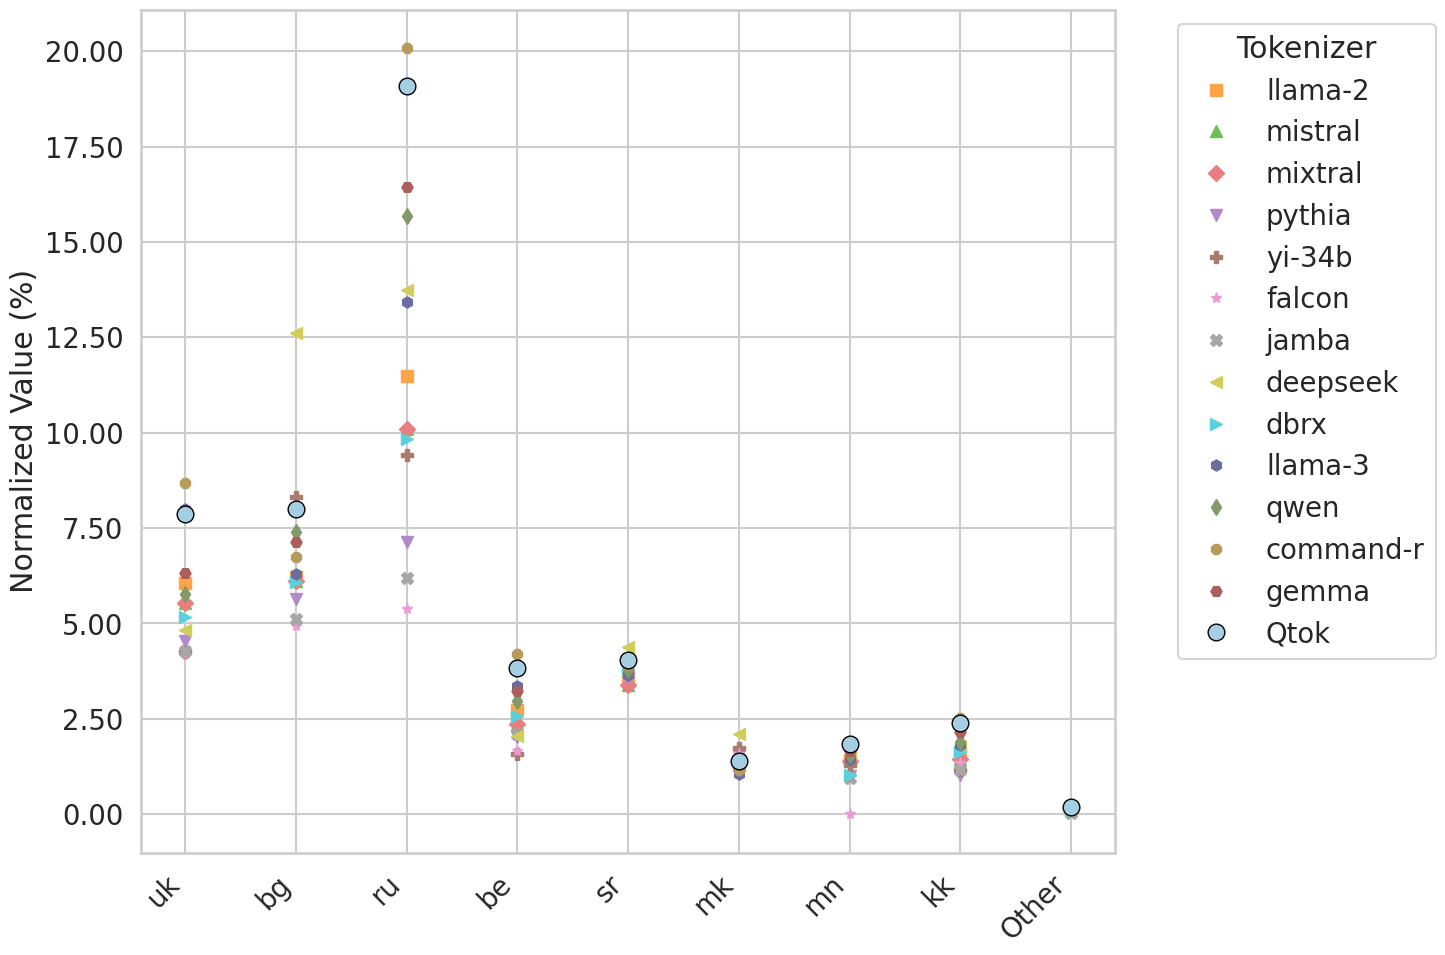

In [78]:
file_path_new = './table4.tsv'
# Call the function to plot with distinct markers and colors
plot_with_distinct_markers_and_colors(file_path_new)